<a href="https://colab.research.google.com/github/njcoop00/N.ozdowski_thesis/blob/master/copy_senior_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup ##

In [0]:
# installs 
# torch, torchvision
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu100' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl torchvision

!pip install tifffile 
!pip install scikit-image



3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [0]:
# imports 
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim

import numpy as np 
from skimage import measure 
import tifffile 


import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
matplotlib.rcParams['axes.grid'] = False

In [0]:
x = torch.ones((100,200))#.cuda()
#x = torch.ones((1,200))
#y = torch.ones((200,400000))
y = torch.ones((200,400000))#.cuda()
#%time z = torch.mm(x,y)

In [0]:
def getz(x, y):
  z = torch.mm(x,y)
  z = z.cpu().numpy()
  return z

#%time z=getz(x,y)

In [0]:
# utils
def connected_components(boundaries):
#2D
#    assert(len(boundaries.shape) == 3)
    assert(len(boundaries.shape) == 4)
    boundaries = boundaries.astype(np.int64)
    ccs = np.zeros_like(boundaries)
    for z in range(ccs.shape[0]):
        ccs[z] = measure.label(boundaries[z])
        
    return ccs

def randomize_ids(segs, seed=None, lim=256):
    """Randomly change segment ids. Useful for visualization purposes"""
    np.random.seed(seed)
    
    segs = np.copy(segs).astype(np.int64)
    size = np.random.randint(lim,2*lim)
    remap = np.random.randint(1,lim+1,size)
    segs[segs != 0] = remap[segs[segs != 0] % size] # dont change 0s
    
    np.random.seed(None)

    return segs

In [0]:
# get data 
#!wget https://github.com/cos485/data/raw/master/isbi2012/train-volume.tif
#!wget https://github.com/cos485/data/raw/master/isbi2012/train-labels.tif
#!wget --no-check-certificate https://physics.princeton.edu/~tully/hcal/train-volume.tif
!wget --no-check-certificate https://physics.princeton.edu/cms/hcal/mdepthPiPt50ieta23.tif
#!wget --no-check-certificate https://physics.princeton.edu/cms/hcal/mdepthMultiPartPt50ieta22-24.tif
#!wget --no-check-certificate https://physics.princeton.edu/~tully/hcal/train-labels.tif
#!wget --no-check-certificate https://physics.princeton.edu/cms/hcal/mdepthPiPt1-5ieta22-24.tif

#imgs = tifffile.imread('train-volume.tif').astype(np.float32)
imgs = tifffile.imread('mdepthPiPt50ieta23.tif').astype(np.float32)
#imgs = tifffile.imread('mdepthMultiPartPt50ieta22-24.tif').astype(np.float32)
#imgs = imgs - np.mean(imgs, axis=(1,2)).reshape((-1,1,1)) # normalize inputs
#imgs = imgs / (np.std(imgs, axis=(1,2)).reshape((-1,1,1)) + 1e-6)
#imgs_pileup = tifffile.imread('mdepthPiPt1-5ieta22-24.tif').astype(np.float32)
#for i in range(400):
#   for j in range(10):
#      indx = (i*10+j)%imgs.shape[0]
#      imgs[i]+=imgs_pileup[indx]

print(imgs.shape)
print(imgs.shape[0])
ipeak = []
iphiext = 0
iphi0 = 17
deltaphi = 4
depthrange=2*(imgs.shape[1]-1)+1
etarange=2*(imgs.shape[2]-1)+1
phirange=2*(imgs.shape[3]+iphiext-1)+1
#cycles through images
for i in range(imgs.shape[0]):
  emax = -1.0
  iphimax = 0
  #cycle through iphi 
  for j in range(imgs.shape[3]):
    edep = 0.0
    for k in range(imgs.shape[1]):   #sum over depth
      for l in range(imgs.shape[2]): #sum over eta
        edep += imgs[i, k, l, j]
    if edep >= emax:
      emax = edep
      iphimax = j
  ipeak.append(iphimax)
#  print(iphimax)
imgspairs = np.zeros(imgs.shape).astype(np.float32)
imgspairs0 = np.zeros(imgs.shape).astype(np.float32)
imgspairs1 = np.zeros(imgs.shape).astype(np.float32)
imgstruth0 = np.zeros(imgs.shape).astype(np.float32)
imgstruth1 = np.zeros(imgs.shape).astype(np.float32)
for i in range(imgs.shape[0]):
  idx1=np.random.randint(imgs.shape[0])
  idx2=np.random.randint(imgs.shape[0])
  for j in range(imgs.shape[3]):
    imgspairs0[i,:,:,(iphi0+j)%imgs.shape[3]]+=imgs[idx1,:,:,(ipeak[idx1]+j)%imgs.shape[3]]
    imgspairs1[i,:,:,(iphi0+deltaphi+j)%imgs.shape[3]]+=imgs[idx2,:,:,(ipeak[idx2]+j)%imgs.shape[3]]
  imgstruth0[i] = (imgspairs0[i]>=imgspairs1[i])&(imgspairs0[i]>0)
  imgstruth1[i] = (imgspairs1[i]>imgspairs0[i])&(imgspairs1[i]>0)
  for j in range(imgs.shape[3]):
    imgspairs[i,:,:,(iphi0+j)%imgs.shape[3]]+=imgs[idx1,:,:,(ipeak[idx1]+j)%imgs.shape[3]]
    imgspairs[i,:,:,(iphi0+deltaphi+j)%imgs.shape[3]]+=imgs[idx2,:,:,(ipeak[idx2]+j)%imgs.shape[3]]

#extend iphi index from [0,35] -> [0,35+12] by tacking on [0,11] to the end - do this for all imgspairs, imgstruth0, imgstruth1
#imgspairsext = np.concatenate((imgspairs[:,:,:,:],imgspairs[:,:,:,0:12]),axis=-1)
#imgstruth0ext = np.concatenate((imgstruth0[:,:,:,:],imgstruth0[:,:,:,0:12]),axis=-1)
#imgstruth1ext = np.concatenate((imgstruth1[:,:,:,:],imgstruth1[:,:,:,0:12]),axis=-1)

#create new zero float32 arrays with extended indices: # events same, depth [0:6] -> [0:12], ieta [0:5] -> [0:10], iphi [0:48] -> [0:96]
imgspairsextb = np.zeros((imgs.shape[0],2*(imgs.shape[1]-1)+1,2*(imgs.shape[2]-1)+1,2*(imgs.shape[3]+iphiext-1)+1)).astype(np.float32)
imgstruth0extb = np.zeros((imgs.shape[0],2*(imgs.shape[1]-1)+1,2*(imgs.shape[2]-1)+1,2*(imgs.shape[3]+iphiext-1)+1)).astype(np.float32)
imgstruth1extb = np.zeros((imgs.shape[0],2*(imgs.shape[1]-1)+1,2*(imgs.shape[2]-1)+1,2*(imgs.shape[3]+iphiext-1)+1)).astype(np.float32)
imgstruthextb = np.zeros((imgs.shape[0],2*(imgs.shape[1]-1)+1,2*(imgs.shape[2]-1)+1,2*(imgs.shape[3]+iphiext-1)+1)).astype(np.float32)
for i in range(imgs.shape[0]):
  for j in range(imgs.shape[1]):
    for k in range(imgs.shape[2]):
      for l in range(imgs.shape[3]+iphiext):
        imgspairsextb[i,2*j,2*k,2*l] = imgspairs[i,j,k,l]
        imgstruth0extb[i,2*j,2*k,2*l] = imgstruth0[i,j,k,l]
        imgstruth1extb[i,2*j,2*k,2*l] = imgstruth1[i,j,k,l]
        imgstruthextb[i,2*j,2*k,2*l] = (imgstruth0extb[i,2*j,2*k,2*l]>0)|(imgstruth1extb[i,2*j,2*k,2*l]>0)
for i in range(imgs.shape[0]):
  for j in range(depthrange):
    for k in range(etarange):
      for l in range(phirange):
        if( ((l%2)==1) and ((k%2)==0) and ((j%2)==0) ):
          imgspairsextb[i,j,k,l]=(imgspairsextb[i,j,k,l-1]+imgspairsextb[i,j,k,l+1])/2.0
          imgstruth0extb[i,j,k,l]=((imgstruth0extb[i,j,k,l-1]>0)&(imgstruth0extb[i,j,k,l+1]>0))
          imgstruth1extb[i,j,k,l]=((imgstruth1extb[i,j,k,l-1]>0)&(imgstruth1extb[i,j,k,l+1]>0))
          imgstruthextb[i,j,k,l]=(imgstruth0extb[i,j,k,l]>0)|(imgstruth1extb[i,j,k,l]>0)
        if( ((l%2)==0) and ((k%2)==1) and ((j%2)==0) ):
          imgspairsextb[i,j,k,l]=(imgspairsextb[i,j,k-1,l]+imgspairsextb[i,j,k+1,l])/2.0          
          imgstruth0extb[i,j,k,l]=((imgstruth0extb[i,j,k-1,l]>0)&(imgstruth0extb[i,j,k+1,l]>0))
          imgstruth1extb[i,j,k,l]=((imgstruth1extb[i,j,k-1,l]>0)&(imgstruth1extb[i,j,k+1,l]>0))
          imgstruthextb[i,j,k,l]=(imgstruth0extb[i,j,k,l]>0)|(imgstruth1extb[i,j,k,l]>0)
        if( ((l%2)==0) and ((k%2)==0) and ((j%2)==1) ):
          imgspairsextb[i,j,k,l]=(imgspairsextb[i,j-1,k,l]+imgspairsextb[i,j+1,k,l])/2.0
          imgstruth0extb[i,j,k,l]=((imgstruth0extb[i,j-1,k,l]>0)&(imgstruth0extb[i,j+1,k,l]>0))
          imgstruth1extb[i,j,k,l]=((imgstruth1extb[i,j-1,k,l]>0)&(imgstruth1extb[i,j+1,k,l]>0))
          imgstruthextb[i,j,k,l]=(imgstruth0extb[i,j,k,l]>0)|(imgstruth1extb[i,j,k,l]>0)
for i in range(imgs.shape[0]):
  for j in range(depthrange):
    for k in range(etarange):
      for l in range(phirange):
        if( ((l%2)==1) and ((k%2)==1) and ((j%2)==0) ):
          imgspairsextb[i,j,k,l]=(imgspairsextb[i,j,k,l-1]+imgspairsextb[i,j,k,l+1]+imgspairsextb[i,j,k-1,l]+imgspairsextb[i,j,k+1,l])/4.0      
          imgstruth0extb[i,j,k,l]=((imgstruth0extb[i,j,k,l-1]>0)&(imgstruth0extb[i,j,k,l+1]>0)&(imgstruth0extb[i,j,k-1,l]>0)&(imgstruth0extb[i,j,k+1,l]>0))
          imgstruth1extb[i,j,k,l]=((imgstruth1extb[i,j,k,l-1]>0)&(imgstruth1extb[i,j,k,l+1]>0)&(imgstruth1extb[i,j,k-1,l]>0)&(imgstruth1extb[i,j,k+1,l]>0)) 
          imgstruthextb[i,j,k,l]=(imgstruth0extb[i,j,k,l]>0)|(imgstruth1extb[i,j,k,l]>0)
        if( ((l%2)==1) and ((k%2)==0) and ((j%2)==1) ):
          imgspairsextb[i,j,k,l]=(imgspairsextb[i,j,k,l-1]+imgspairsextb[i,j,k,l+1]+imgspairsextb[i,j-1,k,l]+imgspairsextb[i,j+1,k,l])/4.0
          imgstruth0extb[i,j,k,l]=((imgstruth0extb[i,j,k,l-1]>0)&(imgstruth0extb[i,j,k,l+1]>0)&(imgstruth0extb[i,j-1,k,l]>0)&(imgstruth0extb[i,j+1,k,l]>0))
          imgstruth1extb[i,j,k,l]=((imgstruth1extb[i,j,k,l-1]>0)&(imgstruth1extb[i,j,k,l+1]>0)&(imgstruth1extb[i,j-1,k,l]>0)&(imgstruth1extb[i,j+1,k,l]>0))
          imgstruthextb[i,j,k,l]=(imgstruth0extb[i,j,k,l]>0)|(imgstruth1extb[i,j,k,l]>0)
        if( ((l%2)==0) and ((k%2)==1) and ((j%2)==1) ):  
          imgspairsextb[i,j,k,l]=(imgspairsextb[i,j,k-1,l]+imgspairsextb[i,j,k+1,l]+imgspairsextb[i,j-1,k,l]+imgspairsextb[i,j+1,k,l])/4.0
          imgstruth0extb[i,j,k,l]=((imgstruth0extb[i,j,k-1,l]>0)&(imgstruth0extb[i,j,k+1,l]>0)&(imgstruth0extb[i,j-1,k,l]>0)&(imgstruth0extb[i,j+1,k,l]>0))
          imgstruth1extb[i,j,k,l]=((imgstruth1extb[i,j,k-1,l]>0)&(imgstruth1extb[i,j,k+1,l]>0)&(imgstruth1extb[i,j-1,k,l]>0)&(imgstruth1extb[i,j+1,k,l]>0))
          imgstruthextb[i,j,k,l]=(imgstruth0extb[i,j,k,l]>0)|(imgstruth1extb[i,j,k,l]>0)
for i in range(imgs.shape[0]):
  for j in range(depthrange):
    for k in range(etarange):
      for l in range(phirange):
        if( ((l%2)==1) and ((k%2)==1) and ((j%2)==1) ):
          imgspairsextb[i,j,k,l]=(imgspairsextb[i,j-1,k-1,l-1]+imgspairsextb[i,j-1,k-1,l+1]+imgspairsextb[i,j-1,k+1,l-1]+imgspairsextb[i,j+1,k-1,l-1]+imgspairsextb[i,j-1,k+1,l+1]+imgspairsextb[i,j+1,k-1,l+1]+imgspairsextb[i,j+1,k+1,l-1]+imgspairsextb[i,j+1,k+1,l+1])/8.0           
          imgstruth0extb[i,j,k,l]=((imgstruth0extb[i,j-1,k-1,l-1]>0)&(imgstruth0extb[i,j-1,k-1,l+1]>0)&(imgstruth0extb[i,j-1,k+1,l-1]>0)&(imgstruth0extb[i,j+1,k-1,l-1]>0)&(imgstruth0extb[i,j-1,k+1,l+1]>0)&(imgstruth0extb[i,j+1,k-1,l+1]>0)&(imgstruth0extb[i,j+1,k+1,l-1]>0)&(imgstruth0extb[i,j+1,k+1,l+1]>0))
          imgstruth1extb[i,j,k,l]=((imgstruth1extb[i,j-1,k-1,l-1]>0)&(imgstruth1extb[i,j-1,k-1,l+1]>0)&(imgstruth1extb[i,j-1,k+1,l-1]>0)&(imgstruth1extb[i,j+1,k-1,l-1]>0)&(imgstruth1extb[i,j-1,k+1,l+1]>0)&(imgstruth1extb[i,j+1,k-1,l+1]>0)&(imgstruth1extb[i,j+1,k+1,l-1]>0)&(imgstruth1extb[i,j+1,k+1,l+1]>0))
          imgstruthextb[i,j,k,l]=(imgstruth0extb[i,j,k,l]>0)|(imgstruth1extb[i,j,k,l]>0)
# fill in odd indices with averages along one odd index (3 times, average of two),
# then along two odd indices (3 times, average of 4) 
# and then along three odd indices (average of 6)
# set truth information for odd indices based boolean AND of neighbors along one odd index (3 times, AND of two),
# then along two odd indices (3 times, AND of 4)
# and then along three odd indices (AND of 6)

#2D
#imgs = imgs[:,0,:,:]

#bdys = tifffile.imread('train-labels.tif')
#bdys = tifffile.imread('mdepthPiPt50ieta23.tif')
#bdys = tifffile.imread('mdepthMultiPartPt50ieta22-24.tif')
#2D
#bdys = bdys[:,0,:,:]
#bdys = (bdys > 0).astype(np.float32)

#segs = connected_components(bdys)

#imgs_trn = imgs[:200]
#imgs_trn = imgspairsext[:200]
imgs_trn = imgspairsextb[:200]
#bdys_trn = bdys[:200]
#bdys_trn = imgstruth0ext[:200]+imgstruth1ext[:200]
bdys_trn = imgstruthextb[:200]
#segs_trn = segs[:200]
segs_trn = connected_components(bdys_trn)

#imgs_val = imgs[200:400]
#imgs_val = imgspairsext[200:400]
imgs_val = imgspairsextb[200:400]
#bdys_val = bdys[200:400]
#bdys_val = imgstruth0ext[200:400]+imgstruth1ext[200:400]
bdys_val = imgstruthextb[200:400]
#segs_val = segs[200:400]
segs_val = connected_components(bdys_val)

print(imgs_trn.shape, imgs_val.shape)

--2019-07-15 11:40:37--  https://physics.princeton.edu/cms/hcal/mdepthPiPt50ieta23.tif
Resolving physics.princeton.edu (physics.princeton.edu)... 128.112.100.6
Connecting to physics.princeton.edu (physics.princeton.edu)|128.112.100.6|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 9780178 (9.3M) [image/tiff]
Saving to: ‘mdepthPiPt50ieta23.tif.1’

mdepthPiPt50ieta23. 100%[===================>]   9.33M  9.15MB/s    in 1.0s    

2019-07-15 11:40:38 (9.15 MB/s) - ‘mdepthPiPt50ieta23.tif.1’ saved [9780178/9780178]

(1000, 6, 5, 36)
1000
(200, 11, 9, 71) (200, 11, 9, 71)


## Visualize Data ##

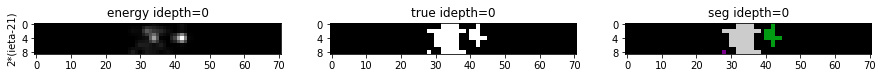

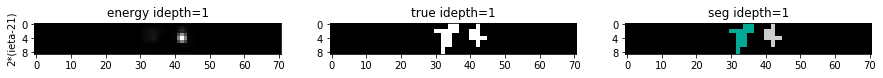

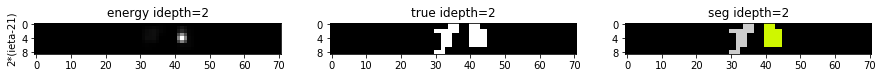

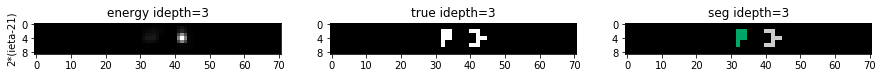

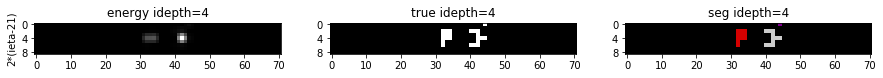

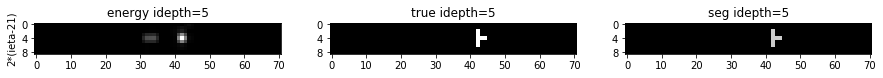

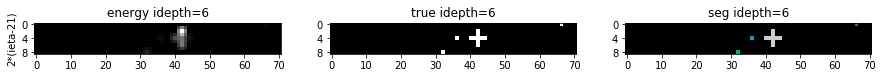

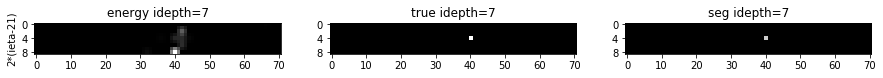

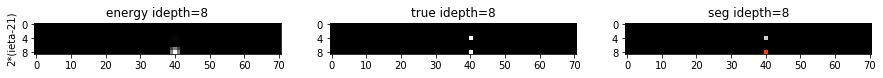

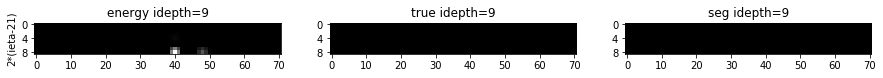

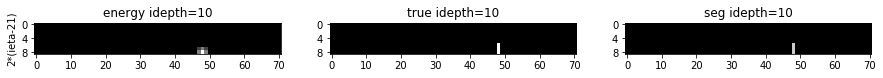

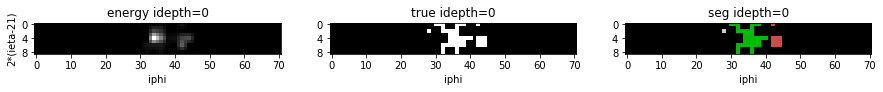

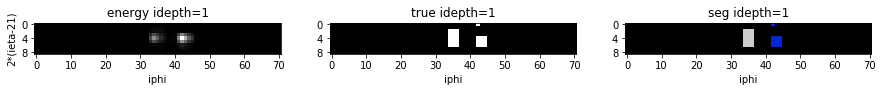

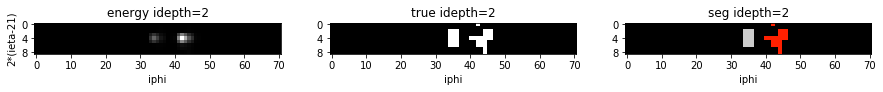

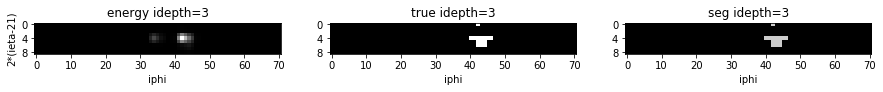

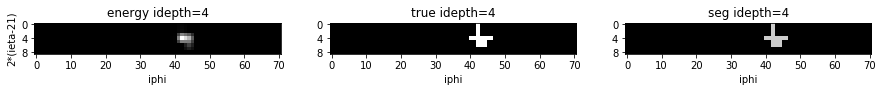

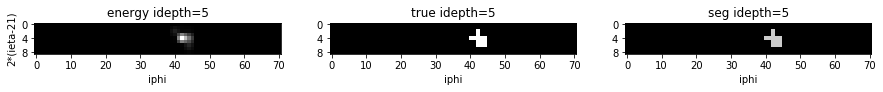

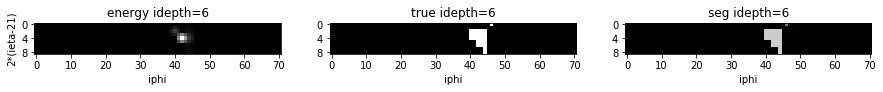

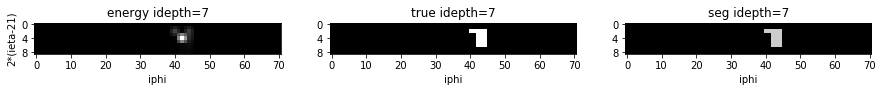

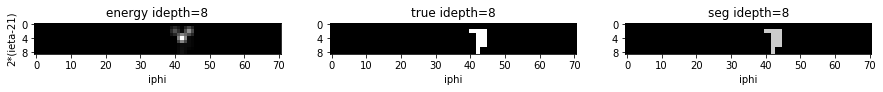

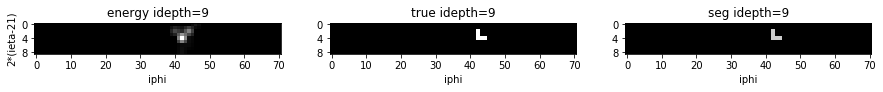

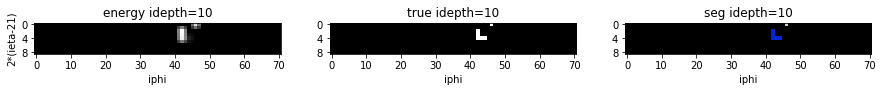

In [0]:
# visualize data 
from matplotlib.colors import LogNorm
#save files
from google.colab import files
#figfinal=plt.figure()
columns = 4
rows = depthrange
for idepth in range(depthrange):
  plt.figure(figsize=(15,5))
  plt.subplot(131)
  plt.title("energy idepth="+str(idepth))
  plt.ylabel("2*(ieta-21)")
  plt.yticks([0,4,8])
#2D
  plt.imshow(imgs_trn[0,idepth], cmap='gray')
  plt.subplot(132)
  plt.title("true idepth="+str(idepth))
  plt.yticks([0,4,8])
#2D
  plt.imshow(bdys_trn[0,idepth], cmap='gray')
  plt.subplot(133)
  plt.title("seg idepth="+str(idepth))
  plt.yticks([0,4,8])
#2D
  plt.imshow(randomize_ids(segs_trn[0,idepth]), cmap='nipy_spectral')
  plt.grid(False)
  plt.show()
  
"""
figdumb = plt.figure(figsize=(20,20))
idepth = 0
i = 0
for i in range (1,rows*columns +1, 3):
  #image1
  #plt.figure(figsize=(15,5))
  plt.title("energy idepth="+str(idepth))
  plt.ylabel("2*(ieta-21)")
  plt.yticks([0,4,8])
  #plt.xlabel("iphi")
  #plt.imshow(imgs_val[0,idepth], cmap='gray')
  figdumb.add_subplot(rows, columns, i)  
  plt.imshow(imgs_val[0,idepth], cmap='gray')
  #image2
  #plt.figure(figsize=(15,5))
  plt.title("true idepth="+str(idepth))
  plt.yticks([0,4,8])
  #plt.xlabel("iphi")
  #plt.imshow(bdys_val[0,idepth], cmap='gray')
  figdumb.add_subplot(rows, columns, i+1)  
  plt.imshow(bdys_val[0,idepth], cmap='gray')
  #image3
  #plt.figure(figsize=(15,5))
  plt.title("seg idepth="+str(idepth))
  plt.yticks([0,4,8])
  #plt.xlabel("iphi")
  #plt.imshow(randomize_ids(segs_val[0,idepth]), cmap='nipy_spectral')
  figdumb.add_subplot(rows, columns, i+2)
  plt.imshow(randomize_ids(segs_val[0,idepth]), cmap='nipy_spectral')
  if i + 2 % 3 == 0:
    idepth = idepth + 1
    
    
figdumb.savefig('images.pdf')
files.download('images.pdf')
    
    
   
  
"""
for idepth in range(depthrange):
  plt.figure(figsize=(15,5))
  plt.subplot(131)
  plt.title("energy idepth="+str(idepth))
  plt.ylabel("2*(ieta-21)")
  plt.yticks([0,4,8])
  plt.xlabel("iphi")
#2D
  plt.imshow(imgs_val[0,idepth], cmap='gray')
  plt.subplot(132)
  plt.title("true idepth="+str(idepth))
  plt.yticks([0,4,8])
  plt.xlabel("iphi")
  #2D
  plt.imshow(bdys_val[0,idepth], cmap='gray')
  plt.subplot(133)
  plt.title("seg idepth="+str(idepth))
  plt.yticks([0,4,8])
  plt.xlabel("iphi")
  #2D
  plt.imshow(randomize_ids(segs_val[0,idepth]), cmap='nipy_spectral')
  plt.savefig("sep"+str(deltaphi)+"_"+str(idepth)+".pdf")
  files.download("sep"+str(deltaphi)+"_"+str(idepth)+".pdf")
  plt.show()



## Create UNet ##

In [0]:
# helper operations 
def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)

def conv3x3x3(in_channels, out_channels):
    return nn.Conv3d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)
  
def maxpool2x2():
    return nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

class UpConv2x2(nn.Module):
    def __init__(self, channels):
        super(UpConv2x2, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(channels, channels // 2,
            kernel_size=2, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.upsample(x)
        x = F.pad(x, (0,1,0,1))
        x = self.conv(x)
        return x 
        
def concat(xh, xv):
    return torch.cat([xh, xv], dim=1)


# unet blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(ConvBlock, self).__init__()
        ## Your code here ##
#2D
#        self.conv1 = conv3x3(in_channels, out_channels)
#        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv1 = conv3x3x3(in_channels, out_channels)
        self.conv2 = conv3x3x3(out_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        ## Your code here ##
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(DownConvBlock, self).__init__()
        ## Your code here ##
        self.downsample = maxpool2x2()
        self.convblock = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        ## Your code here ##
        x = self.downsample(x)
        x = self.convblock(x)
        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(UpConvBlock, self).__init__()
        ## Your code here ##
        self.upsample = UpConv2x2(in_channels)
        self.convblock = ConvBlock(in_channels//2 + out_channels, out_channels)

    def forward(self, xh, xv):
        """
        Args:
            xh: torch Variable, activations from same resolution feature maps (gray arrow in diagram)
            xv: torch Variable, activations from lower resolution feature maps (green arrow in diagram)
        """
        ## Your code here ##
        xv = self.upsample(xv)
        x = concat(xh, xv)
        x = self.convblock(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
#        fs = [16,32,64,128,256]
        fs = [16,32,64,128,256]
        self.conv_in = ConvBlock(1, fs[0])
        self.dconv1 = DownConvBlock(fs[0], fs[1])
        self.dconv2 = DownConvBlock(fs[1], fs[2])
        self.dconv3 = DownConvBlock(fs[2], fs[3])
        self.dconv4 = DownConvBlock(fs[3], fs[4])

        self.uconv1 = UpConvBlock(fs[4], fs[3])
        self.uconv2 = UpConvBlock(fs[3], fs[2])
        self.uconv3 = UpConvBlock(fs[2], fs[1])
        self.uconv4 = UpConvBlock(fs[1], fs[0])
#2D
#        self.conv_out = conv3x3(fs[0], 1)
        self.conv_out = conv3x3x3(fs[0], 1)
        
        self._initialize_weights()

    def forward(self, x):
        ## Your code here ##
        x = self.conv_in(x)
#        d1 = self.dconv1(x)
#        d2 = self.dconv2(d1)
#        d3 = self.dconv3(d2)
#        d4 = self.dconv4(d3)
#        u1 = self.uconv1(d3, d4)
#        u2 = self.uconv2(d2, u1)
#        u3 = self.uconv3(d1, u2)
#        u4 = self.uconv4(x, u3)
#        x = self.conv_out(u4)
        x = self.conv_out(x)
        return x

    def _initialize_weights(self):
#2D
#        conv_modules = [m for m in self.modules() if isinstance(m, nn.Conv2d)]
        conv_modules = [m for m in self.modules() if isinstance(m, nn.Conv3d)]
        for m in conv_modules:
            ## Your code here ##
            for m in conv_modules:
#3D
              n = m.weight.shape[0]*m.weight.shape[1]*m.weight.shape[2]*m.weight.shape[3]
              m.weight.data.normal_(0, np.sqrt(2. / n))
              m.bias.data.zero_()
            pass


## Train UNet ##

In [0]:
# train utils
def np2var(arr, cuda):
    arr = np.expand_dims(np.expand_dims(arr, 0), 0)
    arr = torch.from_numpy(arr)
    arr = Variable(arr)
    if cuda:
        arr = arr.cuda()
    return arr

def var2np(arr):
    arr = arr.data.cpu().numpy()[0,0]
    return arr
    

In [0]:
# plot utils
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)

def plot(step, log_every, train_loss, val_loss, img_trn, img_val, pred_trn, pred_val, true_trn, true_val):
    clear_output(wait=False)
    plt.gcf().clear()
   
    plt.subplot(241)
    iters = np.arange(0,len(train_loss))*log_every
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    plot_learning([train_plot, val_plot], "Loss")
    plt.title("Cross entropy loss")

#3D
#    for idepth in range(6):
#      plt.subplot(242)
#      plt.imshow(img_trn[idepth], cmap='gray')
#      plt.title("Input image, train, idepth="+str(idepth))
#    
#      plt.subplot(243)
#      plt.imshow(pred_trn[idepth], cmap='gray')
#      plt.title("Predicted, train, idepth="+str(idepth))
#    
#      plt.subplot(244)
#      plt.imshow(true_trn[idepth], cmap='gray')
#      plt.title("True, train, idepth="+str(idepth))
#    
#      plt.subplot(246)
#      plt.imshow(img_val[idepth], cmap='gray')
#      plt.title("Input image, val, idepth="+str(idepth))
#    
#      plt.subplot(247)
#      plt.imshow(pred_val[idepth], cmap='gray')
#      plt.title("Predicted, val, idepth="+str(idepth))    
#    
#      plt.subplot(248)
#      plt.imshow(true_val[idepth], cmap='gray')
#      plt.title("True, val, idepth="+str(idepth))

    plt.gcf().set_size_inches(18, 7)
    display(plt.gcf())

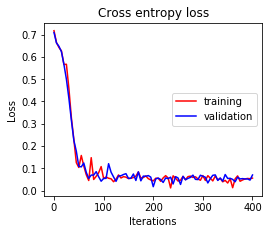

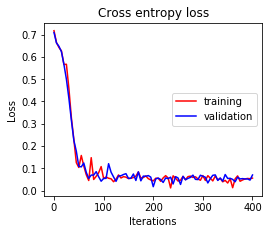

In [0]:
## Train network ##

from google.colab import files

# params
USECUDA = True
max_iter = 500
log_every = 5
plot_every = 100
lr = 0.001

# create net
net = UNet()
if USECUDA:
    net.cuda()
    
# create optimizer 
optimizer = optim.Adam(net.parameters(), lr=lr)

# train net
losses_trn = []
losses_val = []
for t in range(max_iter):
    # choose sample
    idx = np.random.randint(0,imgs_trn.shape[0])
    img, bdy = imgs_trn[idx], bdys_trn[idx]
    
    # format
    img = np2var(img, cuda=USECUDA)
    bdy = np2var(bdy, cuda=USECUDA)
    
    # forward, backward, update
    optimizer.zero_grad()
    pred = net(img)
    loss = F.binary_cross_entropy_with_logits(pred, bdy)
    loss.backward()
    optimizer.step()
    

    # log stuff
    if t % log_every == 0: 
        # validation info
        idx = np.random.randint(0,imgs_val.shape[0])
        img_val, bdy_val = imgs_val[idx], bdys_val[idx]

        # format
        img_val = np2var(img_val, cuda=USECUDA)
        bdy_val = np2var(bdy_val, cuda=USECUDA)

        # forward
        pred_val = net(img_val)
        loss_val = F.binary_cross_entropy_with_logits(pred_val, bdy_val)

        # store
#        losses_trn.append(loss.data[0])
#        losses_val.append(loss_val.data[0])
        losses_trn.append(loss.data.item())
        losses_val.append(loss_val.data.item()) 

    # plot stuff
    if t % plot_every == 0:
        plot(t, log_every, losses_trn, losses_val, 
             var2np(img), var2np(img_val),
             var2np(F.sigmoid(pred)), var2np(F.sigmoid(pred_val)),
             var2np(bdy), var2np(bdy_val))

    

In [0]:
# clear output after running
clear_output()

## Make Segmentations ##

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


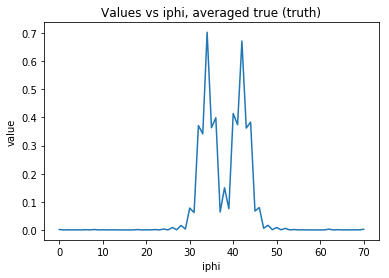

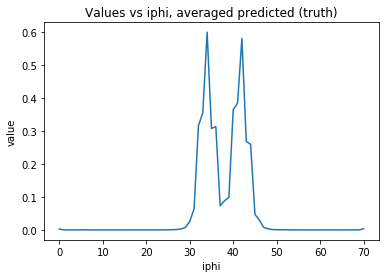

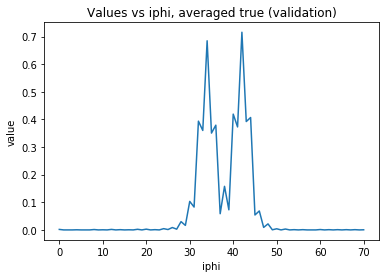

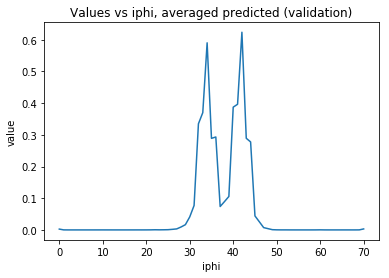

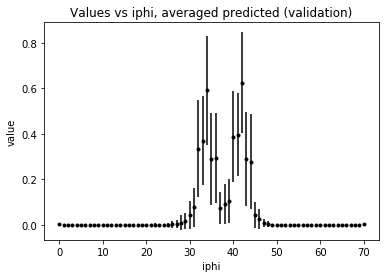

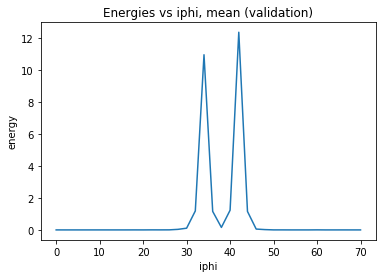

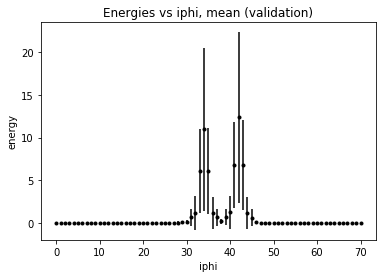

In [0]:
#save files
from google.colab import files

# inspect outputs
def plot_boundaries(im1, im2, im3):
    for idepth in range(depthrange):
      plt.figure(figsize=(15,5))
      plt.subplot(131)
      plt.ylabel("ieta-21")
      plt.yticks([0,2,4])
      if(idepth==5): plt.xlabel("iphi")
#2D
      plt.title("energy idepth="+str(idepth))
      plt.imshow(im1[idepth], cmap='gray')
      plt.subplot(132)
      plt.yticks([0,2,4])
      if(idepth==5): plt.xlabel("iphi")
#2D
      plt.title("true idepth="+str(idepth))
      plt.imshow(im2[idepth], cmap='gray')
      plt.subplot(133)
      plt.yticks([0,2,4])
      if(idepth==5): plt.xlabel("iphi")
#2D
      plt.title("net idepth="+str(idepth))
      plt.imshow(im3[idepth], cmap='gray')
      plt.show()
  

    
    
#create method of plotting values
def plot_values_true(phis, true):
  for idepth in range(depthrange):
    plt.title("Values vs iphi, true for idepth"+str(idepth))
    plt.xlabel("iphi")
    plt.ylabel("value")
    plt.plot(phis,true[idepth,4])
    plt.show()
  
#create method of plotting values
def plot_values_pred(phis, predict):
  for idepth in range(depthrange):
    plt.title("Values vs iphi, predicted for idepth"+str(idepth))
    plt.xlabel("iphi")
    plt.ylabel("value")
    plt.plot(phis,predict[idepth,4])
    plt.show

# combine all depths
def plot_values_trucomb(phis,true):
  for idepth in range(depthrange):
    plt.title("true values vs iphi, combined depths")
    plt.xlabel("iphi")
    plt.ylabel("value")
    plt.plot(phis,true[idepth,4])
  plt.show()

# combine all depths
def plot_values_predcomb(phis,predict):
  for idepth in range(depthrange):
    plt.title("predicted values vs iphi, combined depths")
    plt.xlabel("iphi")
    plt.ylabel("value")
    plt.plot(phis,predict[idepth,4])
  plt.show()
  
avgavgt = np.zeros((200,phirange)).astype(np.float32)
avgavgv = np.zeros((200,phirange)).astype(np.float32)
avgavgtruet = np.zeros((200,phirange)).astype(np.float32)
avgavgtruev = np.zeros((200,phirange)).astype(np.float32)
avgavgenergyv = np.zeros((200,phirange)).astype(np.float32)


# training set
for z in range(200):
  imgt = imgs_trn[z]
  truet = bdys_trn[z]
  predt = var2np(F.sigmoid(net(np2var(imgt, cuda=USECUDA))))
#  plot_boundaries(img, true, pred)

#print(pred[0,2,17],pred[0,2,21])

# validation set
  imgv = imgs_val[z]
  truev = bdys_val[z]
  predv = var2np(F.sigmoid(net(np2var(imgv, cuda=USECUDA))))
#  plot_boundaries(img, true, pred)

  iphi = np.arange(phirange)
#  for idepth in range(11):
#    for j in range(95):
#      print(truev[idepth,4,j])
#      print(predv[idepth,4,j])
#  iphit = []
#  iphiv = []
#  for i in range(95):
#    iphit.append(i)
#    iphiv.append(i)
#    print(iphit[i],predt[0,2,i])
#    print(iphiv[i],predv[0,2,i])
    
#  avgspredt = []
#  avgspredv = []
  for i in range(phirange):
#    sumt = 0
#    sumv = 0 
#    avgt = 0
#    avgv = 0
    for idepth in range(depthrange):
      avgavgt[z,i] = avgavgt[z,i] + predt[idepth,4,i]
      avgavgv[z,i] = avgavgv[z,i] + predv[idepth,4,i]
    avgavgt[z,i] = avgavgt[z,i] / depthrange
    avgavgv[z,i] = avgavgv[z,i] / depthrange
#  avgspred.append(avg)
#    for j in range(95):
#      print(avgavgt[z,j])
#  avgstrue = []
  for i in range(phirange):
    for idepth in range(depthrange):
      avgavgtruet[z,i] = avgavgtruet[z,i] +truet[idepth,4,i]
      avgavgtruev[z,i] = avgavgtruev[z,i] +truev[idepth,4,i]
    avgavgtruet[z,i] = avgavgtruet[z,i] / depthrange
    avgavgtruev[z,i] = avgavgtruev[z,i] / depthrange
  for i in range(phirange):
      for idepth in range(depthrange):
        avgavgenergyv[z,i] = avgavgenergyv[z,i] +imgv[idepth,4,i]
      avgavgenergyv[z,i] = avgavgenergyv[z,i] / depthrange
#    sum = 0
#   avg = 0
#    for idepth in range(11):
#      sum = sum + true[idepth,4,i]
#    avg = sum / 11
#    avgstrue.append(avg)

#plot_values_true(iphi,true)
#plot_values_pred(iphi,pred)

#plot_values_trucomb(iphi,true)
#plot_values_predcomb(iphi,pred)

avgstrue = np.mean(avgavgtruet,axis=0)
avgspred = np.mean(avgavgt,axis=0)
avgstruestd = np.std(avgavgtruet,axis=0)
avgspredstd = np.std(avgavgt,axis=0)

avgsenergyv = np.mean(avgavgenergyv,axis=0)
avgsenergystd = np.std(avgavgenergyv,axis=0)

avgstruev = np.mean(avgavgtruev,axis=0)
avgspredv = np.mean(avgavgv,axis=0)
avgstruestdv = np.std(avgavgtruev,axis=0)
avgspredstdv = np.std(avgavgv,axis=0)

plt.title("Values vs iphi, averaged true (truth)")
plt.xlabel("iphi")
plt.ylabel("value")
plt.plot(iphi,avgstrue)
#plt.errorbar(x=iphi,y=avgstrue,yerr=avgstruestd,marker='.',linestyle='',color='black')
#plt.savefig(str(deltaphi)+'avgtrutru.pdf')
#files.download(str(deltaphi)+'avgtrutru.pdf')
plt.show()


plt.title("Values vs iphi, averaged predicted (truth)")
plt.xlabel("iphi")
plt.ylabel("value")
plt.plot(iphi,avgspred)
#plt.savefig(str(deltaphi)+'avgpredtru.pdf')
#files.download(str(deltaphi)+'avgpredtru.pdf')
plt.show()      

plt.title("Values vs iphi, averaged true (validation)")
plt.xlabel("iphi")
plt.ylabel("value")
plt.plot(iphi,avgstruev)
#plt.errorbar(x=iphi,y=avgstruev,yerr=avgstruestdv,marker='.',linestyle='',color='black')
#plt.savefig(str(deltaphi)+'avgtruval.pdf')
#files.download(str(deltaphi)+'avgtruval.pdf')
plt.show()

plt.title("Values vs iphi, averaged predicted (validation)")
plt.xlabel("iphi")
plt.ylabel("value")
plt.plot(iphi,avgspredv)
#plt.errorbar(x=iphi,y=avgspredv,yerr=avgspredstdv,marker='.',linestyle='',color='black')
#plt.savefig(str(deltaphi)+'avgpredval.pdf')
#files.download(str(deltaphi)+'avgpredval.pdf')
plt.show() 

plt.title("Values vs iphi, averaged predicted (validation)")
plt.xlabel("iphi")
plt.ylabel("value")
#plt.plot(iphi,avgspredv)
plt.errorbar(x=iphi,y=avgspredv,yerr=avgspredstdv,marker='.',linestyle='',color='black')
#plt.savefig(str(deltaphi)+'stdpredval.pdf')
#files.download(str(deltaphi)+'stdpredval.pdf')
plt.show() 

plt.title("Energies vs iphi, mean (validation)")
plt.xlabel("iphi")
plt.ylabel("energy")
plt.plot(iphi,avgsenergyv)
#plt.errorbar(x=iphi,y=avgstrue,yerr=avgstruestd,marker='.',linestyle='',color='black')
#plt.savefig(str(deltaphi)+'avgenergyval.pdf')
#files.download(str(deltaphi)+'avgenergyval.pdf')
plt.show()

plt.title("Energies vs iphi, mean (validation)")
plt.xlabel("iphi")
plt.ylabel("energy")
#plt.plot(iphi,avgsenergyv)
plt.errorbar(x=iphi,y=avgsenergyv,yerr=avgsenergystd,marker='.',linestyle='',color='black')
#plt.savefig(str(deltaphi)+'stdenergyval.pdf')
#files.download(str(deltaphi)+'stdenergyval.pdf')
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


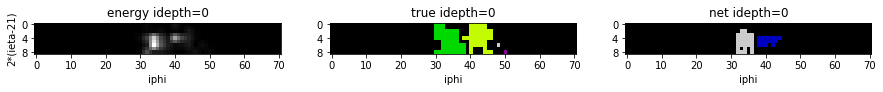

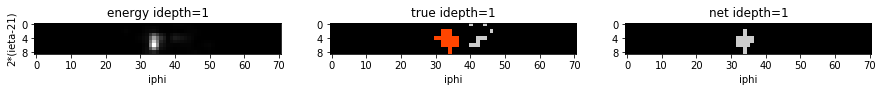

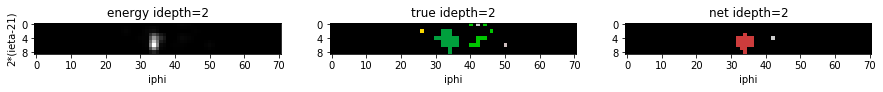

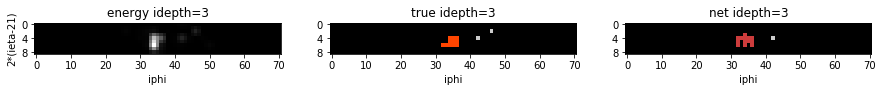

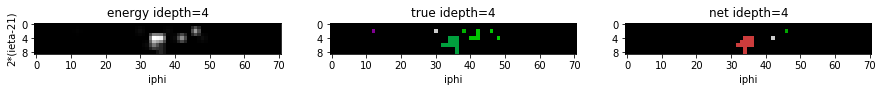

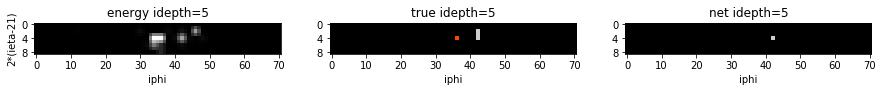

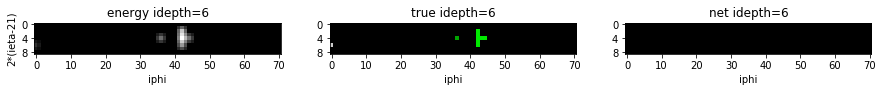

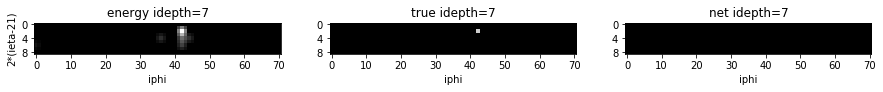

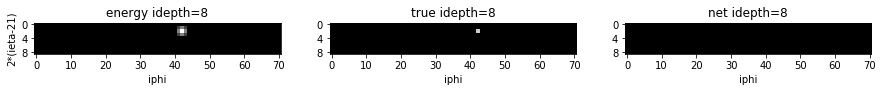

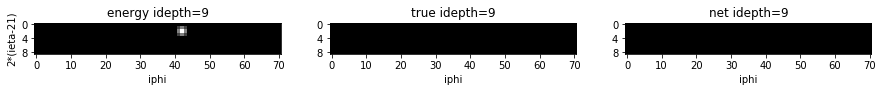

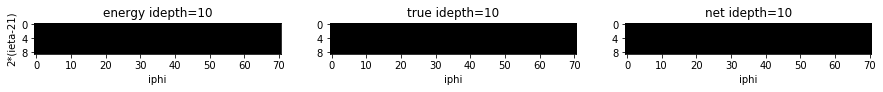

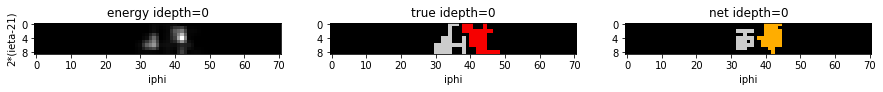

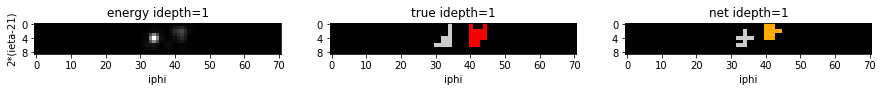

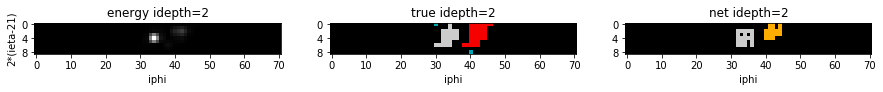

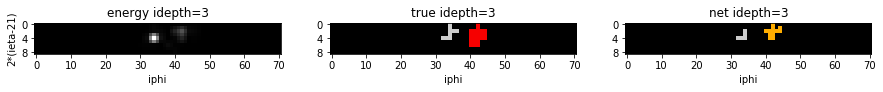

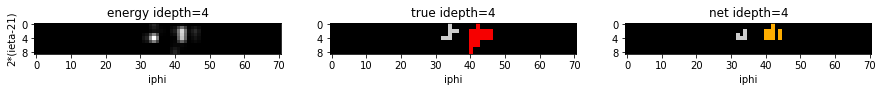

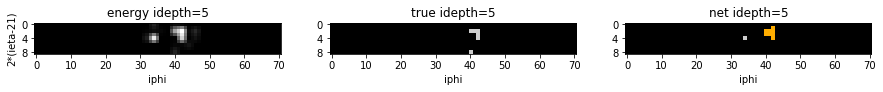

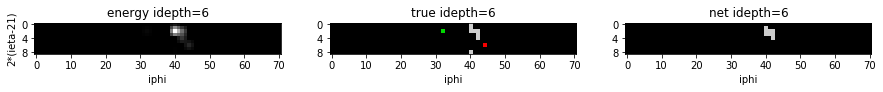

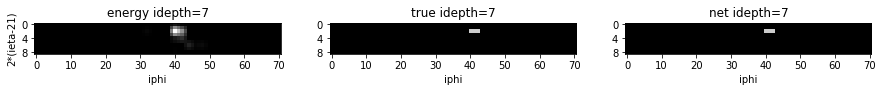

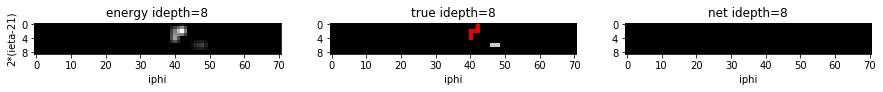

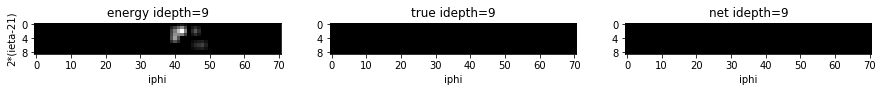

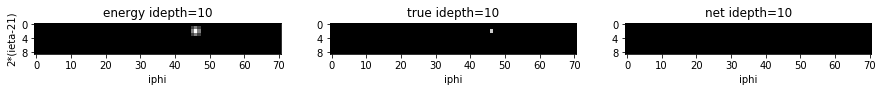

In [0]:
## analyze results
def plot_segmentations(im1, im2, im3):
    for idepth in range(depthrange):
      plt.figure(figsize=(15,5))
      plt.subplot(131)
      plt.title("energy idepth="+str(idepth))
      plt.ylabel("2*(ieta-21)")
      plt.yticks([0,4,8])
      plt.xlabel("iphi")
#2D
      plt.imshow(im1[idepth], cmap='gray')
      plt.subplot(132)
      plt.title("true idepth="+str(idepth))
      plt.yticks([0,4,8])
      plt.xlabel("iphi")
#2D
      plt.imshow(im2[idepth], cmap='nipy_spectral')
      plt.subplot(133)
      plt.title("net idepth="+str(idepth))
      plt.yticks([0,4,8])
      plt.xlabel("iphi")
#2D
      plt.imshow(im3[idepth], cmap='nipy_spectral')
      plt.show()
    
# training 
z = 45
img = imgs_trn[z]
bdy_true = bdys_trn[z]
seg_true = segs_trn[z]
bdy_pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA)))) > 0.5
seg_true = randomize_ids(seg_true)
seg_pred = randomize_ids(connected_components(np.expand_dims(bdy_pred, 0))[0])
plot_segmentations(img, seg_true, seg_pred)

# validation 
z = 89
img = imgs_val[z]
bdy_true = bdys_val[z]
seg_true = segs_val[z]
bdy_pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA)))) > 0.5
seg_true = randomize_ids(seg_true)
seg_pred = randomize_ids(connected_components(np.expand_dims(bdy_pred, 0))[0])
plot_segmentations(img, seg_true, seg_pred)

## Receptive Field ##

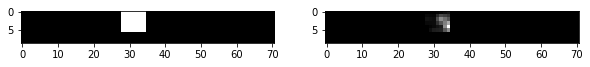

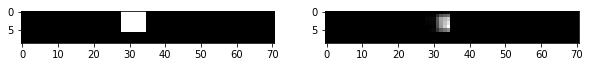

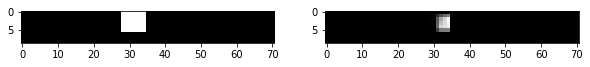

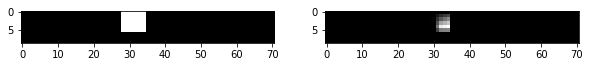

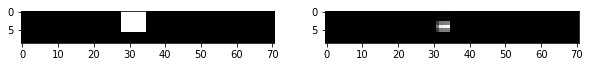

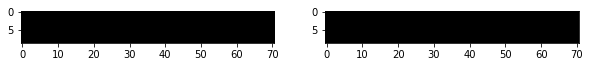

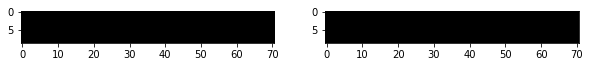

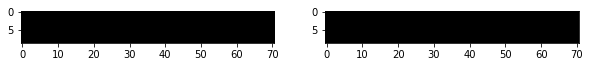

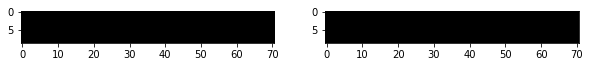

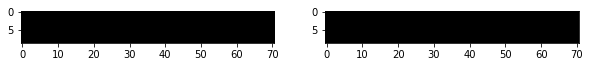

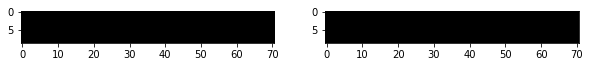

In [0]:
def input_gradient(img, net, z, y, x):
    """Compute the gradient of the output pixel (y,x) with respect to the input image
    Args:
        img: torch Variable, input image
        net: torch network, randomly initialized weights
        y, x: ints, location of pixel for which to compute gradient
    Output:
        grad: float 32 numpy array, gradient of pixel with respect to input image 
                grad.shape = (img.shape[2], img.shape[3])
    """
    ## Your code here ##
    out = net(img)
    pixel = out[0,0,z,y,x]
    pixel.backward()
    return var2np(img.grad)
#    raise NotImplementedError
    

random_net = UNet()
img = Variable(torch.from_numpy(np.expand_dims(np.expand_dims(imgs_trn[0], 0), 0)), requires_grad=True)
#3D
loc = (1,2,31)
grad = input_gradient(img, random_net, loc[0], loc[1], loc[2])
nonzero = (grad != 0.0)

for idepth in range(depthrange):
  plt.figure(figsize=(10,5))
  plt.subplot(121)
  plt.imshow(nonzero[idepth], cmap='gray')

  im = np.copy(imgs_trn[0])
  im[~nonzero] = 0.0
  plt.subplot(122)
  plt.imshow(im[idepth], cmap='gray')
  plt.show()
  